In [ ]:
import os
from functools import partial
from itertools import product

import lightgbm as lgbm
import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
import seaborn as sns
from pygod.utils import load_data
from sklearn.ensemble import IsolationForest
from sklearn.metrics import make_scorer, roc_auc_score
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.neighbors import KNeighborsClassifier, LocalOutlierFactor
from sklearn.preprocessing import StandardScaler

from NEExT.collections import EgonetCollection
from NEExT.experiment_utils.data_loading import load_abcdo_data, load_pygod_data
from NEExT.experiment_utils.embed import build_embeddings, build_features
from NEExT.experiment_utils.models import score_unlabeled_gt
from NEExT.io import GraphIO
from NEExT.outliers import CosineOutlierDetector, OutlierDataset

%reload_ext autoreload
%autoreload 2

In [ ]:
graph_io = GraphIO()
hide_frac = {0: 0.8, 1: 0.8}

# edges_df, mapping_df, features_df, ground_truth_df = load_pygod_data(hide_frac=hide_frac)
edges_df, mapping_df, features_df, ground_truth_df = load_abcdo_data(hide_frac=hide_frac)

graph_data = {
    "target": "is_outlier",
    "skip_features": [],
    "feature_list": [],
    # "feature_list": [i for i in features_df.columns[1:-1]],
}

In [ ]:
graph_collection = graph_io.load_from_dfs(
    edges_df=edges_df,
    node_graph_df=mapping_df,
    node_features_df=features_df,
    graph_type="igraph",
    filter_largest_component=False,
)
subgraph_collection = EgonetCollection()
subgraph_collection.create_egonets_from_graphs(
    graph_collection=graph_collection,
    egonet_target=graph_data["target"],
    egonet_algorithm="k_hop_egonet",
    skip_features=graph_data["skip_features"],
    max_hop_length=1,
)
structural_features, features = build_features(subgraph_collection, feature_vector_length=5, feature_list=graph_data["feature_list"])

In [ ]:
embeddings = build_embeddings(
    subgraph_collection,
    structural_features,
    features,
    strategy="structural_embedding",
    structural_embedding_dimension=5,
    feature_embedding_dimension=5,
    embedding_algorithm="approx_wasserstein",
    # approx_wasserstein, wasserstein, sinkhornvectorizer
)
dataset = OutlierDataset(subgraph_collection, embeddings, standardize=False)

In [92]:
from typing import List, Literal, Optional
import lightgbm as lgb
from sklearn.base import BaseEstimator, RegressorMixin, ClassifierMixin
from sklearn.utils.validation import check_is_fitted
from sklearn.model_selection import train_test_split


class LGBMOutlier(ClassifierMixin, BaseEstimator):
    def __init__(
        self,
        n_estimators: int = 10,
        min_data_in_leaf: int = 1,
        num_leaves: int = 10,
        max_depth: int = 10,
        class_weight: Literal[None, "balanced"] = "balanced",
        learning_rate: float = 1e-1,
        reg_alpha: float = 0.0,
        reg_lambda: float = 0.0,
        colsample_bytree: float = 1.0,
        **kwargs,
    ):
        self.n_estimators = n_estimators
        self.min_data_in_leaf = min_data_in_leaf
        self.num_leaves = num_leaves
        self.max_depth = max_depth
        self.class_weight = class_weight
        self.learning_rate = learning_rate
        self.reg_alpha = reg_alpha
        self.reg_lambda = reg_lambda
        self.colsample_bytree = colsample_bytree
        
        self.hyperparameters = {
            "objective": "binary",
            "metric": "auc",
            "random_state": 42,
        } | {
            "n_estimators": self.n_estimators,
            "min_data_in_leaf": self.min_data_in_leaf,
            "num_leaves": self.num_leaves,
            "max_depth": self.max_depth,
            "class_weight": self.class_weight,
            "learning_rate": self.learning_rate,
            "reg_alpha": self.reg_alpha,
            "reg_lambda": self.reg_lambda,
            "colsample_bytree": self.colsample_bytree,
        }

    def fit(self, X, y):
        X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)
        train_set = lgb.Dataset(X_train, label=y_train)
        val_set = lgb.Dataset(X_val, label=y_val)

        self.model_ = lgb.train(
            self.hyperparameters,
            train_set=train_set,
            valid_sets=[val_set],
            callbacks=[
                lgb.early_stopping(stopping_rounds=5),
            ],
        )
        self.classes_ = np.array([0.0, 1.0])
        return self

    def predict(self, X):
        check_is_fitted(self)
        return np.where(self.model_.predict(X) >= 0.5, 1, 0)
    
    def predict_proba(self, X):
        check_is_fitted(self)
        out = np.zeros((len(X), 2))
        out[:, 1] = self.model_.predict(X)
        out[:, 0] = 1- out[:, 1]
        return out

In [107]:
def objective(trial: optuna.Trial, model: str):
    if model == "cosine":
        top_k = trial.suggest_int("top_k", 1, 20)
        detector = CosineOutlierDetector(top_k=top_k)
    elif model == "knn":
        n_neighbors = trial.suggest_int("n_neighbors", 1, 50)
        detector = KNeighborsClassifier(n_neighbors=n_neighbors)
    elif model == "lgbm":
        params = {
            "n_estimators": trial.suggest_int("n_estimators", 1, 75),
            "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 10),
            "num_leaves": trial.suggest_int("num_leaves", 1, 100),
            "max_depth": trial.suggest_int("max_depth", 1, 100),
            "class_weight": trial.suggest_categorical("class_weight", [None, "balanced"]),
            "learning_rate": trial.suggest_float("learning_rate", 1e-5, 1e1, log=True),
            "reg_alpha": trial.suggest_float("learning_rate", 1e-5, 1e1, log=True),
            "reg_lambda": trial.suggest_float("learning_rate", 1e-5, 1e1, log=True),
            "colsample_bytree": trial.suggest_float("colsample_bytree", 0.2, 1),
        }

        detector = LGBMOutlier(**params)

    metric = cross_val_score(
        detector,
        dataset.X_labeled,
        dataset.y_labeled,
        cv=StratifiedKFold(5),
        n_jobs=-1,
        scoring=make_scorer(roc_auc_score),
    )
    return metric.mean()

In [108]:
model = "lgbm"
study = optuna.create_study(direction="maximize")
study.optimize(partial(objective, model=model), n_trials=50, n_jobs=4)

[I 2025-03-30 19:37:14,582] A new study created in memory with name: no-name-34d348ad-df91-4df3-a9f2-b881fb2fbbdd
[I 2025-03-30 19:37:14,737] Trial 1 finished with value: 0.815625 and parameters: {'n_estimators': 57, 'min_data_in_leaf': 5, 'num_leaves': 45, 'max_depth': 57, 'class_weight': 'balanced', 'learning_rate': 2.628784812117367, 'colsample_bytree': 0.9936925253491129}. Best is trial 1 with value: 0.815625.
[I 2025-03-30 19:37:14,799] Trial 0 finished with value: 0.753125 and parameters: {'n_estimators': 20, 'min_data_in_leaf': 6, 'num_leaves': 36, 'max_depth': 92, 'class_weight': 'balanced', 'learning_rate': 1.057478948158403, 'colsample_bytree': 0.8516123576749615}. Best is trial 1 with value: 0.815625.
[I 2025-03-30 19:37:14,846] Trial 3 finished with value: 0.5 and parameters: {'n_estimators': 46, 'min_data_in_leaf': 4, 'num_leaves': 37, 'max_depth': 69, 'class_weight': 'balanced', 'learning_rate': 0.0010821383348426394, 'colsample_bytree': 0.5623365418671473}. Best is trial

[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Info] Number of positive: 24, number of negative: 96
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000020 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 163
[LightGBM] [Info] Number of data points in the train set: 120, number of used features: 5
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.200000 -> initscore=-1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 5 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

[I 2025-03-30 19:37:14,869] Trial 2 finished with value: 0.5 and parameters: {'n_estimators': 46, 'min_data_in_leaf': 8, 'num_leaves': 55, 'max_depth': 36, 'class_weight': 'balanced', 'learning_rate': 0.027459083990815807, 'colsample_bytree': 0.7045183256493128}. Best is trial 1 with value: 0.815625.
[I 2025-03-30 19:37:14,918] Trial 4 finished with value: 0.84375 and parameters: {'n_estimators': 47, 'min_data_in_leaf': 10, 'num_leaves': 74, 'max_depth': 43, 'class_weight': 'balanced', 'learning_rate': 0.5998732934135407, 'colsample_bytree': 0.6790018806225397}. Best is trial 4 with value: 0.84375.
[I 2025-03-30 19:37:14,970] Trial 5 finished with value: 0.684375 and parameters: {'n_estimators': 49, 'min_data_in_leaf': 2, 'num_leaves': 37, 'max_depth': 35, 'class_weight': None, 'learning_rate': 4.8026181256214295, 'colsample_bytree': 0.298835493986936}. Best is trial 4 with value: 0.84375.
[I 2025-03-30 19:37:15,022] Trial 6 finished with value: 0.5 and parameters: {'n_estimators': 23,

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[6]	valid_0's auc: 0.966797
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Info] Number of positive: 24, number of negative: 96
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000018 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 176
[LightGBM] [Info] Number of data points in the train set: 120, number of used features: 5
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.200000 -> initscore=-1.386294
[LightGBM] [Info] Start training from score -1.3

[I 2025-03-30 19:37:15,104] Trial 8 finished with value: 0.5 and parameters: {'n_estimators': 30, 'min_data_in_leaf': 7, 'num_leaves': 68, 'max_depth': 18, 'class_weight': 'balanced', 'learning_rate': 0.008916312674970851, 'colsample_bytree': 0.7366588399545992}. Best is trial 4 with value: 0.84375.
[I 2025-03-30 19:37:15,176] Trial 9 finished with value: 0.5 and parameters: {'n_estimators': 53, 'min_data_in_leaf': 9, 'num_leaves': 6, 'max_depth': 8, 'class_weight': None, 'learning_rate': 1.53542671515467e-05, 'colsample_bytree': 0.9855594417779561}. Best is trial 4 with value: 0.84375.
[I 2025-03-30 19:37:15,239] Trial 10 finished with value: 0.5 and parameters: {'n_estimators': 13, 'min_data_in_leaf': 2, 'num_leaves': 49, 'max_depth': 31, 'class_weight': None, 'learning_rate': 0.0033368102335182797, 'colsample_bytree': 0.22682822242897124}. Best is trial 4 with value: 0.84375.
[I 2025-03-30 19:37:15,272] Trial 11 finished with value: 0.5 and parameters: {'n_estimators': 58, 'min_data

[LightGBM] [Info] Number of positive: 24, number of negative: 96
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000030 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 163
[LightGBM] [Info] Number of data points in the train set: 120, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.200000 -> initscore=-1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1]	valid_0's auc: 0.957031
[LightGBM] [Info] Number of positive: 24, number of negative: 96
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000028 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 168
[LightGBM] [Info] Number of data points in the train set: 120, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: 

[I 2025-03-30 19:37:15,294] Trial 12 finished with value: 0.5 and parameters: {'n_estimators': 2, 'min_data_in_leaf': 1, 'num_leaves': 42, 'max_depth': 86, 'class_weight': 'balanced', 'learning_rate': 0.0007699976022192736, 'colsample_bytree': 0.7931171942592867}. Best is trial 4 with value: 0.84375.
[I 2025-03-30 19:37:15,494] Trial 13 finished with value: 0.540625 and parameters: {'n_estimators': 75, 'min_data_in_leaf': 10, 'num_leaves': 99, 'max_depth': 55, 'class_weight': None, 'learning_rate': 0.14437833003628253, 'colsample_bytree': 0.4776150380620928}. Best is trial 4 with value: 0.84375.
[I 2025-03-30 19:37:15,601] Trial 15 finished with value: 0.55625 and parameters: {'n_estimators': 75, 'min_data_in_leaf': 4, 'num_leaves': 98, 'max_depth': 54, 'class_weight': 'balanced', 'learning_rate': 0.21146168624354922, 'colsample_bytree': 0.9622706056444166}. Best is trial 4 with value: 0.84375.


[LightGBM] [Info] Number of positive: 24, number of negative: 96
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000019 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 163
[LightGBM] [Info] Number of data points in the train set: 120, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.200000 -> initscore=-1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 5 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Light

[I 2025-03-30 19:37:15,647] Trial 14 finished with value: 0.659375 and parameters: {'n_estimators': 69, 'min_data_in_leaf': 10, 'num_leaves': 99, 'max_depth': 57, 'class_weight': 'balanced', 'learning_rate': 0.30759146098653206, 'colsample_bytree': 0.9771858366811814}. Best is trial 4 with value: 0.84375.
[I 2025-03-30 19:37:15,705] Trial 16 finished with value: 0.540625 and parameters: {'n_estimators': 72, 'min_data_in_leaf': 4, 'num_leaves': 95, 'max_depth': 56, 'class_weight': 'balanced', 'learning_rate': 0.22887229149668875, 'colsample_bytree': 0.9527224762954443}. Best is trial 4 with value: 0.84375.


[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Info] Number of positive: 24, number of negative: 96
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000019 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 176
[LightGBM] [Info] Number of data points in the train set: 120, number of used features: 5
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.200000 -> initscore=-1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 5 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

[I 2025-03-30 19:37:15,862] Trial 17 finished with value: 0.7 and parameters: {'n_estimators': 37, 'min_data_in_leaf': 4, 'num_leaves': 81, 'max_depth': 52, 'class_weight': 'balanced', 'learning_rate': 0.4021825011375225, 'colsample_bytree': 0.9674190952114893}. Best is trial 4 with value: 0.84375.
[I 2025-03-30 19:37:15,990] Trial 18 finished with value: 0.65 and parameters: {'n_estimators': 35, 'min_data_in_leaf': 4, 'num_leaves': 77, 'max_depth': 48, 'class_weight': 'balanced', 'learning_rate': 7.571143764357325, 'colsample_bytree': 0.6293650805859266}. Best is trial 4 with value: 0.84375.
[I 2025-03-30 19:37:16,037] Trial 19 finished with value: 0.775 and parameters: {'n_estimators': 38, 'min_data_in_leaf': 4, 'num_leaves': 79, 'max_depth': 45, 'class_weight': 'balanced', 'learning_rate': 9.806022647346756, 'colsample_bytree': 0.639030854673613}. Best is trial 4 with value: 0.84375.
[I 2025-03-30 19:37:16,082] Trial 20 finished with value: 0.7375 and parameters: {'n_estimators': 40

[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Info] Number of positive: 24, number of negative: 96
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000018 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 163
[LightGBM] [Info] Number of data points in the train set: 120, number of used features: 5
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.200000 -> initscore=-1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 5 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

[I 2025-03-30 19:37:16,220] Trial 21 finished with value: 0.69375 and parameters: {'n_estimators': 59, 'min_data_in_leaf': 8, 'num_leaves': 66, 'max_depth': 69, 'class_weight': 'balanced', 'learning_rate': 7.373101400426571, 'colsample_bytree': 0.63769177438573}. Best is trial 4 with value: 0.84375.


[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Info] Number of positive: 24, number of negative: 96
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000018 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 163
[LightGBM] [Info] Number of data points in the train set: 120, number of used features: 5
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.200000 -> initscore=-1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 5 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

[I 2025-03-30 19:37:16,353] Trial 22 finished with value: 0.790625 and parameters: {'n_estimators': 61, 'min_data_in_leaf': 8, 'num_leaves': 23, 'max_depth': 67, 'class_weight': 'balanced', 'learning_rate': 2.478414335301553, 'colsample_bytree': 0.8567761166130967}. Best is trial 4 with value: 0.84375.
[I 2025-03-30 19:37:16,419] Trial 23 finished with value: 0.76875 and parameters: {'n_estimators': 61, 'min_data_in_leaf': 8, 'num_leaves': 67, 'max_depth': 67, 'class_weight': 'balanced', 'learning_rate': 1.5553295721292981, 'colsample_bytree': 0.8692394877530147}. Best is trial 4 with value: 0.84375.
[I 2025-03-30 19:37:16,431] Trial 24 finished with value: 0.7375 and parameters: {'n_estimators': 61, 'min_data_in_leaf': 7, 'num_leaves': 66, 'max_depth': 67, 'class_weight': 'balanced', 'learning_rate': 1.7792503259433112, 'colsample_bytree': 0.8540309142965912}. Best is trial 4 with value: 0.84375.
[I 2025-03-30 19:37:16,516] Trial 25 finished with value: 0.71875 and parameters: {'n_est

set: 120, number of used features: 5
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.200000 -> initscore=-1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 5 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[4]	va

[I 2025-03-30 19:37:16,786] Trial 26 finished with value: 0.7625 and parameters: {'n_estimators': 61, 'min_data_in_leaf': 8, 'num_leaves': 22, 'max_depth': 65, 'class_weight': 'balanced', 'learning_rate': 1.2609482743359088, 'colsample_bytree': 0.8839557734870449}. Best is trial 4 with value: 0.84375.
[I 2025-03-30 19:37:16,807] Trial 28 finished with value: 0.5 and parameters: {'n_estimators': 52, 'min_data_in_leaf': 9, 'num_leaves': 20, 'max_depth': 81, 'class_weight': 'balanced', 'learning_rate': 0.06387078677347321, 'colsample_bytree': 0.8981938397782194}. Best is trial 4 with value: 0.84375.
[I 2025-03-30 19:37:16,846] Trial 27 finished with value: 0.5 and parameters: {'n_estimators': 53, 'min_data_in_leaf': 9, 'num_leaves': 23, 'max_depth': 79, 'class_weight': 'balanced', 'learning_rate': 0.049029409187603026, 'colsample_bytree': 0.8541548888608337}. Best is trial 4 with value: 0.84375.


[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Info] Number of positive: 24, number of negative: 96
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000018 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 163
[LightGBM] [Info] Number of data points in the train set: 120, number of used features: 5
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.200000 -> initscore=-1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 5 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

[I 2025-03-30 19:37:16,900] Trial 29 finished with value: 0.5 and parameters: {'n_estimators': 53, 'min_data_in_leaf': 9, 'num_leaves': 23, 'max_depth': 62, 'class_weight': None, 'learning_rate': 0.050542568369495666, 'colsample_bytree': 0.7564913000439516}. Best is trial 4 with value: 0.84375.
[I 2025-03-30 19:37:17,179] Trial 30 finished with value: 0.5 and parameters: {'n_estimators': 53, 'min_data_in_leaf': 9, 'num_leaves': 21, 'max_depth': 76, 'class_weight': None, 'learning_rate': 0.062018229923582385, 'colsample_bytree': 0.7515169081823774}. Best is trial 4 with value: 0.84375.
[I 2025-03-30 19:37:17,234] Trial 32 finished with value: 0.740625 and parameters: {'n_estimators': 67, 'min_data_in_leaf': 7, 'num_leaves': 2, 'max_depth': 96, 'class_weight': None, 'learning_rate': 0.6791654320933206, 'colsample_bytree': 0.7578662535640729}. Best is trial 4 with value: 0.84375.
[I 2025-03-30 19:37:17,282] Trial 31 finished with value: 0.5 and parameters: {'n_estimators': 54, 'min_data_i

[LightGBM] [Info] Number of positive: 24, number of negative: 96
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000019 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 163
[LightGBM] [Info] Number of data points in the train set: 120, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.200000 -> initscore=-1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 5 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early 

[I 2025-03-30 19:37:17,683] Trial 34 finished with value: 0.790625 and parameters: {'n_estimators': 43, 'min_data_in_leaf': 3, 'num_leaves': 91, 'max_depth': 96, 'class_weight': 'balanced', 'learning_rate': 0.5490758543347563, 'colsample_bytree': 0.5256172727907701}. Best is trial 4 with value: 0.84375.
[I 2025-03-30 19:37:17,704] Trial 36 finished with value: 0.690625 and parameters: {'n_estimators': 43, 'min_data_in_leaf': 3, 'num_leaves': 85, 'max_depth': 43, 'class_weight': 'balanced', 'learning_rate': 3.013017011050578, 'colsample_bytree': 0.6875833973221332}. Best is trial 4 with value: 0.84375.
[I 2025-03-30 19:37:17,772] Trial 35 finished with value: 0.75 and parameters: {'n_estimators': 43, 'min_data_in_leaf': 6, 'num_leaves': 88, 'max_depth': 41, 'class_weight': 'balanced', 'learning_rate': 3.466403514078899, 'colsample_bytree': 0.6873441076856383}. Best is trial 4 with value: 0.84375.


[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Info] Number of positive: 24, number of negative: 96
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000019 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 163
[LightGBM] [Info] Number of data points in the train set: 120, number of used features: 5
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.200000 -> initscore=-1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 5 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

[I 2025-03-30 19:37:17,807] Trial 37 finished with value: 0.69375 and parameters: {'n_estimators': 31, 'min_data_in_leaf': 3, 'num_leaves': 86, 'max_depth': 48, 'class_weight': 'balanced', 'learning_rate': 2.2110086894992356, 'colsample_bytree': 0.5357886605896002}. Best is trial 4 with value: 0.84375.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Early stopping, best iteration is:
[2]	valid_0's auc: 0.976562


[I 2025-03-30 19:37:18,122] Trial 38 finished with value: 0.80625 and parameters: {'n_estimators': 46, 'min_data_in_leaf': 3, 'num_leaves': 88, 'max_depth': 100, 'class_weight': 'balanced', 'learning_rate': 3.3386781618963455, 'colsample_bytree': 0.4851395969363305}. Best is trial 4 with value: 0.84375.
[I 2025-03-30 19:37:18,145] Trial 39 finished with value: 0.63125 and parameters: {'n_estimators': 47, 'min_data_in_leaf': 6, 'num_leaves': 90, 'max_depth': 88, 'class_weight': 'balanced', 'learning_rate': 2.623175860145544, 'colsample_bytree': 0.5653975432686843}. Best is trial 4 with value: 0.84375.
[I 2025-03-30 19:37:18,170] Trial 40 finished with value: 0.83125 and parameters: {'n_estimators': 47, 'min_data_in_leaf': 3, 'num_leaves': 31, 'max_depth': 100, 'class_weight': 'balanced', 'learning_rate': 0.6979992288714679, 'colsample_bytree': 0.5279476581289884}. Best is trial 4 with value: 0.84375.


[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Info] Number of positive: 24, number of negative: 96
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000018 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 163
[LightGBM] [Info] Number of data points in the train set: 120, number of used features: 5
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.200000 -> initscore=-1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 5 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

[I 2025-03-30 19:37:18,263] Trial 41 finished with value: 0.5 and parameters: {'n_estimators': 48, 'min_data_in_leaf': 5, 'num_leaves': 45, 'max_depth': 100, 'class_weight': 'balanced', 'learning_rate': 0.016096786314040042, 'colsample_bytree': 0.5482450727835254}. Best is trial 4 with value: 0.84375.
[I 2025-03-30 19:37:18,553] Trial 43 finished with value: 0.5 and parameters: {'n_estimators': 48, 'min_data_in_leaf': 5, 'num_leaves': 46, 'max_depth': 34, 'class_weight': 'balanced', 'learning_rate': 0.022383636061760047, 'colsample_bytree': 0.4330630977706796}. Best is trial 4 with value: 0.84375.
[I 2025-03-30 19:37:18,559] Trial 42 finished with value: 0.5 and parameters: {'n_estimators': 46, 'min_data_in_leaf': 5, 'num_leaves': 32, 'max_depth': 88, 'class_weight': 'balanced', 'learning_rate': 0.016473094041974518, 'colsample_bytree': 0.445473707581526}. Best is trial 4 with value: 0.84375.
[I 2025-03-30 19:37:18,614] Trial 44 finished with value: 0.5 and parameters: {'n_estimators':

[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Info] Number of positive: 24, number of negative: 96
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000026 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 163
[LightGBM] [Info] Number of data points in the train set: 120, number of used features: 5
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.200000 -> initscore=-1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 5 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

[I 2025-03-30 19:37:18,936] Trial 46 finished with value: 0.759375 and parameters: {'n_estimators': 65, 'min_data_in_leaf': 2, 'num_leaves': 33, 'max_depth': 61, 'class_weight': 'balanced', 'learning_rate': 0.7757767339849776, 'colsample_bytree': 0.34265928056173367}. Best is trial 45 with value: 0.853125.
[I 2025-03-30 19:37:18,978] Trial 47 finished with value: 0.73125 and parameters: {'n_estimators': 64, 'min_data_in_leaf': 2, 'num_leaves': 31, 'max_depth': 61, 'class_weight': 'balanced', 'learning_rate': 0.9630323397422511, 'colsample_bytree': 0.3816476710359628}. Best is trial 45 with value: 0.853125.
[I 2025-03-30 19:37:19,012] Trial 48 finished with value: 0.759375 and parameters: {'n_estimators': 66, 'min_data_in_leaf': 2, 'num_leaves': 55, 'max_depth': 61, 'class_weight': 'balanced', 'learning_rate': 0.8265813528180053, 'colsample_bytree': 0.3281349822467964}. Best is trial 45 with value: 0.853125.
[I 2025-03-30 19:37:19,034] Trial 49 finished with value: 0.759375 and paramete

[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Info] Number of positive: 24, number of negative: 96
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000020 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 163
[LightGBM] [Info] Number of data points in the train set: 120, number of used features: 5
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.200000 -> initscore=-1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 5 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

In [109]:
if model == "cosine":
    detector = CosineOutlierDetector(**study.best_params)
elif model == "knn":
    detector = KNeighborsClassifier(**study.best_params)
elif model == "lgbm":
    detector = LGBMOutlier(**study.best_params)
    # detector = LGBMOutlier()
detector.fit(dataset.X_labeled, dataset.y_labeled)
out_df, score = score_unlabeled_gt(dataset, detector, ground_truth_df)
score

[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Info] Number of positive: 30, number of negative: 120
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002141 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 217
[LightGBM] [Info] Number of data points in the train set: 150, number of used features: 5
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.200000 -> initscore=-1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 5 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

0.8587500000000001

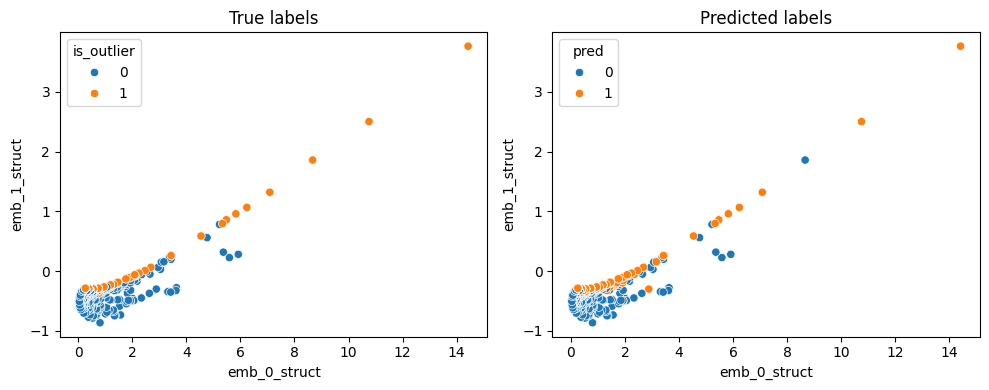

In [110]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

sns.scatterplot(x=embeddings.embeddings_df.iloc[:, 1], y=embeddings.embeddings_df.iloc[:, 2], hue=ground_truth_df["is_outlier"], ax=ax[0])
ax[0].set_title("True labels")

sns.scatterplot(x=embeddings.embeddings_df.iloc[:, 1], y=embeddings.embeddings_df.iloc[:, 2], hue=out_df["pred"], ax=ax[1])
ax[1].set_title("Predicted labels")

fig.tight_layout()